## Libraries

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Emotion Recognition"

/content/drive/MyDrive/Emotion Recognition


In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import datetime
from sklearn.model_selection import train_test_split

from face_extraction import extract_faces
from configurations import *

In [ ]:
!pip install scikit-image
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Train Test Split

In [4]:
# Train Test Split
random_seed = 2024
df_description = pd.read_excel("dataset/data_description.xlsx", usecols= ['video_location','participant_id','emotion'])

# Perform one-hot encoding
one_hot_encoded = pd.get_dummies(df_description['emotion'])

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_description = pd.concat([df_description, one_hot_encoded], axis=1)

train_idx, test_idx, _, _ = train_test_split(
    df_description.index.values,
    df_description['emotion'].values,
    test_size=0.2,
    stratify=df_description['emotion'].values,
    random_state=random_seed
)

train_df = df_description.loc[train_idx]
test_df = df_description.loc[test_idx]

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

print('\nClasses in the train set:')
print(train_df['emotion'].value_counts())

print('\nClasses in the test set:')
print(test_df['emotion'].value_counts())

Total videos for training: 174
Total videos for testing: 44

Classes in the train set:
emotion
angry        34
neutral      32
surprised    31
happy        30
sad          28
fear         19
Name: count, dtype: int64

Classes in the test set:
emotion
angry        9
neutral      8
surprised    8
happy        7
sad          7
fear         5
Name: count, dtype: int64


In [5]:
# For Model Test cases:
train_df  = train_df[:30]
test_df = test_df[:15]

print(f"Total videos for training: {len(train_df)}")

print('\nClasses in the train set:')
print(train_df['emotion'].value_counts())


print('\nClasses in the test set:')
print(test_df['emotion'].value_counts())

Total videos for training: 30

Classes in the train set:
emotion
sad          9
neutral      7
fear         5
happy        3
surprised    3
angry        3
Name: count, dtype: int64

Classes in the test set:
emotion
angry        5
surprised    4
neutral      2
fear         2
happy        1
sad          1
Name: count, dtype: int64


In [6]:
def load_video(path, target_frame_size, max_frames=0):
    cap = cv2.VideoCapture(path)


    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(round(original_fps / target_fps))

    frames = []

    count = 0
    try:
        while len(frames) < MAX_SEQ_LENGTH:

            ret, frame = cap.read()
            if not ret:
                break

            if count % frame_interval == 0:
                frame = frame[:, :, [2, 1, 0]]
                face_obj = extract_faces(frame, target_size = target_frame_size, enforce_detection = False)
                frames.append(face_obj[0][0][0])

                if len(frames) == max_frames:
                    break

            count = count+1

    finally:
        cap.release()
    return np.array(frames)

In [30]:
### Test loading a single video

# path = './dataset/participant_5/participant5_sad1.mp4'
# target_frame_size = (IMG_SIZE, IMG_SIZE)
# frames = load_video(path, target_frame_size)

## Loading all training data to memory

In [7]:
def prepare_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_location"].values.tolist()

    #labels = df["emotion"].values
    #labels = label_processor(labels[..., None]).numpy()
    labels = np.asarray(df[df.columns[-6:]].values, dtype=float)

    x_train = np.zeros(
            shape=(num_samples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32"
            )
    # For each video.
    for idx, path in enumerate(video_paths):

        # Loading all of the frames of a video, extract faces and resize
        frames = load_video(os.path.join(root_dir, path), target_frame_size = (IMG_SIZE, IMG_SIZE))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate((frames, padding))

        x_train[idx] = frames
        print(f'Video Loaded {idx+1}')

    return x_train, labels

In [8]:
x_train, y_train = prepare_videos(train_df, "")
x_test, y_test = prepare_videos(test_df,"")

print(f'Shape of train data : {x_train.shape}')
print(f'Shape of test data : {x_test.shape}')


Video Loaded 1
Video Loaded 2
Video Loaded 3
Video Loaded 4
Video Loaded 5
Video Loaded 6
Video Loaded 7
Video Loaded 8
Video Loaded 9
Video Loaded 10
Video Loaded 11
Video Loaded 12
Video Loaded 13
Video Loaded 14
Video Loaded 15
Video Loaded 16
Video Loaded 17
Video Loaded 18
Video Loaded 19
Video Loaded 20
Video Loaded 21
Video Loaded 22
Video Loaded 23
Video Loaded 24
Video Loaded 25
Video Loaded 26
Video Loaded 27
Video Loaded 28
Video Loaded 29
Video Loaded 30
Video Loaded 1
Video Loaded 2
Video Loaded 3
Video Loaded 4
Video Loaded 5
Video Loaded 6
Video Loaded 7
Video Loaded 8
Video Loaded 9
Video Loaded 10
Video Loaded 11
Video Loaded 12
Video Loaded 13
Video Loaded 14
Video Loaded 15
Shape of train data : (30, 20, 160, 160, 3)
Shape of test data : (15, 20, 160, 160, 3)


In [56]:
## Saving & loading the training array
# TO Save
# np.save('preprocessed_dataset/x_train.npy',x_train)
# np.save('preprocessed_dataset/y_train.npy',y_train)
# np.save('preprocessed_dataset/x_test.npy',x_test)
# np.save('preprocessed_dataset/y_test.npy',y_test)


# TO Load
x_train = np.load('preprocessed_dataset/x_train.npy')
y_train = np.load('preprocessed_dataset/y_train.npy')
x_test = np.load('preprocessed_dataset/x_test.npy')
y_test = np.load('preprocessed_dataset/y_test.npy')


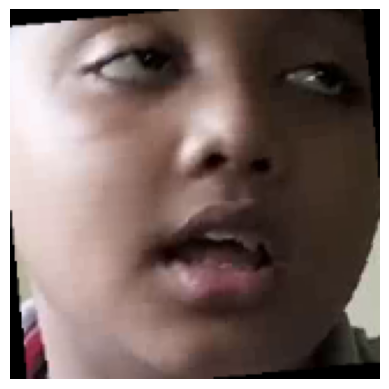

In [57]:
# To see a frame in train data


img_array = x_train[1][0]
plt.imshow(img_array)
plt.axis('off')  # Turn off axis
plt.show()

In [10]:
# Turing them into tf data input pipeline
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

## Modeling

In [9]:
import cnn_x_model as ml_model
# import cnn_lstm_model as ml_model
# import cnn_gru_model as ml_model
# import resnet50_x_model as ml_model
# import resnet50_lstm_model as ml_model
# import resnet50_gru_model as ml_model

In [50]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 160, 160, 3   0         
                             )]                                  
                                                                 
 time_distributed (TimeDist  (None, 20, 8192)          23587712  
 ributed)                                                        
                                                                 
 gru (GRU)                   (None, 20, 32)            789696    
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198   

### Training Model

In [11]:
'''
Run Summary:


'''
model_name = 'cnn_transformer'
checkpoint_path = "models/checkpoints/"
tb_log_dir = "tb_logs/"+ model_name + datetime.datetime.now().strftime("_%m_%d-%H_%M")

def run_experiment():
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1
    )

    # log_dir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir, histogram_freq=1)

    model = ml_model.get_compiled_model()
    print(model.summary())

    # history = model.fit(x_train,
    #                     y_train,
    #                     validation_data = (x_test, y_test),
    #                     epochs = EPOCHS,
    #                     batch_size = batch_size,
    #                     callbacks = [checkpoint, tensorboard_callback],
    #                     )

    history = model.fit(train_ds,
                        validation_data = test_ds,
                        epochs = EPOCHS,
                        callbacks = [checkpoint, tensorboard_callback],
                        )


    model.load_weights(checkpoint_path)
    loss, accuracy = model.evaluate(x_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model


In [ ]:
# Opening Tensorboard
%load_ext tensorboard

In [14]:
trained_model = run_experiment()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 160, 160, 3)  0         
                             ]                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 512)          30317184  
 tributed)                                                       
                                                                 
 frame_position_embedding (P  (None, 20, 512)          10240     
 ositionalEmbedding)                                             
                                                                 
 transformer_layer (Transfor  (None, 20, 512)          1085984   
 merEncoder)                                                     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0   

ResourceExhaustedError: Graph execution error:

Detected at node 'model_3/time_distributed_1/model_2/conv2d_5/Relu' defined at (most recent call last):
    File "d:\anaconda\envs\AI\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\anaconda\envs\AI\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "d:\anaconda\envs\AI\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\anaconda\envs\AI\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "d:\anaconda\envs\AI\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "d:\anaconda\envs\AI\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "d:\anaconda\envs\AI\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "d:\anaconda\envs\AI\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "d:\anaconda\envs\AI\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\anaconda\envs\AI\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "d:\anaconda\envs\AI\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "d:\anaconda\envs\AI\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "d:\anaconda\envs\AI\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "d:\anaconda\envs\AI\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "d:\anaconda\envs\AI\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "d:\anaconda\envs\AI\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "d:\anaconda\envs\AI\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\anaconda\envs\AI\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\anaconda\envs\AI\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\anaconda\envs\AI\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Tanima\AppData\Local\Temp\ipykernel_66856\3283350932.py", line 1, in <module>
      trained_model = run_experiment()
    File "C:\Users\Tanima\AppData\Local\Temp\ipykernel_66856\1252475036.py", line 31, in run_experiment
      history = model.fit(train_ds,
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\layers\rnn\time_distributed.py", line 252, in call
      y = self.layer(inputs, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "d:\anaconda\envs\AI\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "d:\anaconda\envs\AI\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_3/time_distributed_1/model_2/conv2d_5/Relu'
OOM when allocating tensor with shape[40,64,156,156] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_3/time_distributed_1/model_2/conv2d_5/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6241]

## Inference

In [ ]:
## Implement with threading or multiprocessing to make runtime faster

def inference(video_path, step):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
    class_vocab = label_processor.get_vocabulary()
    emotion = ''

    frame_count = 0
    step_count = 0
    try:
      while True:
        ret, frame = cap.read()
        step_count = step_count+1

        if not ret:
          break

        frame = frame[:, :, [2, 1, 0]]
        face_obj = extract_faces(frame, target_size = (IMG_SIZE, IMG_SIZE), enforce_detection = False)
        bbox = face_obj[0][1]
        x = int(bbox['x'])
        y = int(bbox['y'])
        w = int(bbox['w'])
        h = int(bbox['h'])


        if step_count == step:
             frames.append(face_obj[0][0][0])
             frame_count = frame_count+1
             step_count = 0

        if frame_count == MAX_SEQ_LENGTH:
            frames = np.array(frames)
            if np.mean(frames) > 0.0:
                frame_features[0, :, :] = np.array(feature_extractor(frames))
            else:
                frame_features[0, :, :] = 0.0

            frame_count = 0
            frames = []

            probabilities = trained_model.predict(frame_features)[0]
            emotion = class_vocab[np.argmax(probabilities)]



        frame = frame[:, :, [2, 1, 0]]

        frame = np.ascontiguousarray(frame, dtype=np.uint8)
        cv2.rectangle(frame, (x,y), (x+w, y + h),(0,255,0),3)
        cv2.putText(frame, emotion, (x,y-20), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,0), 1)

        cv2.imshow("Frame",frame)
        #key = cv2.waitKey(1)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    finally:
        cap.release()
        cv2.destroyAllWindows()

In [ ]:
inference('dataset/participant_2/participant2_sad1.mp4', 1)

1/1 [==============================] - 0s 24ms/step
